In [ ]:
# Instala la herramienta Consola del archivo ISIC
!pip install isic-cli #Sacada desde el repositorio de Github https://github.com/ImageMarkup/isic-cli/blob/master/README.md

# Se actualizan las librerías a versiones compatibles para resolver los conflictos.
!pip install tensorflow==2.19.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.4 MB/s eta 0:00:00


In [ ]:
#Descargar Imagenes + Metadatos
!isic image download --search "" --collections "249" --limit 0 BCN20000/ # Imagenes y Metadatos de BCN20000

#Comando extraido desde la misma ISIC ARCHIVE https://api.isic-archive.com/images/?query=&collections=249

If you have been granted special permissions, logging in with `isic user login` might return more data.


Successfully downloaded 18,946 images to BCN20000/.
Successfully wrote 18,946 metadata records to BCN20000/metadata.csv.
Successfully wrote attributions to BCN20000/attribution.txt.
Successfully wrote 1 license(s) to BCN20000/licenses.


In [ ]:
import csv

def cargar_metadatos_Benignos(archivo, diagnosis_col_name='diagnosis_3'):

    CLASES_VALIDAS = {'Nevus', 'Solar lentigo', 'Seborrheic keratosis', 'Dermatofibroma', 'Scar'}

    # Usamos un dict estándar vacío
    ids_por_clase = {}

    try:
        with open(archivo, 'r', encoding='utf-8') as f:
            reader = csv.reader(f)
            header = next(reader)

            try:
                id_col_idx = header.index('isic_id')
                diagnosis_col_idx = header.index(diagnosis_col_name)
            except ValueError as e:
                print(f"Error: No se encontró la columna requerida ('{e.args[0]}') en el archivo CSV.")
                return None

            for fila in reader:
                if len(fila) > diagnosis_col_idx and len(fila) > id_col_idx:
                    diagnosis = fila[diagnosis_col_idx]
                    isic_id = fila[id_col_idx]

                    # Si la clase no es válida, se ignora la fila.
                    if diagnosis in CLASES_VALIDAS:

                        # Si es la primera vez que vemos esta clase, crear la lista
                        if diagnosis not in ids_por_clase:
                            ids_por_clase[diagnosis] = []

                        # Añadir el ID
                        ids_por_clase[diagnosis].append(isic_id)

        print("Datos extraídos y filtrados por clase (usando dict estándar):")
        return ids_por_clase

    except FileNotFoundError:
        print(f"Error: Archivo {archivo} no encontrado")
        return None
    except Exception as e:
        print(f"Error al procesar el archivo: {e}")
        return None

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
from tqdm import tqdm

def organizar_imagenes_en_carpetas(carpeta_origen, ids_por_clase, carpeta_destino_base, test_size=0.3, random_state=42):

    def copiar_archivos(ids, carpeta_destino):
        """ Copia una lista de IDs de imagen a una carpeta de destino. """
        os.makedirs(carpeta_destino, exist_ok=True)
        for id_img in tqdm(ids, desc=f'Copiando a {os.path.basename(carpeta_destino)}'):
            nombre_archivo = f"{id_img}.jpg" # Asume extensión .jpg
            ruta_origen = os.path.join(carpeta_origen, nombre_archivo)
            ruta_destino = os.path.join(carpeta_destino, nombre_archivo)

            if os.path.exists(ruta_origen):
                shutil.copy(ruta_origen, ruta_destino)
            else:
                print(f"Advertencia: No se encontró el archivo {ruta_origen}")

    if not ids_por_clase:
        print("No se proporcionaron datos (ids_por_clase está vacío). No se copiarán archivos.")
        return

    nombres_de_clases = list(ids_por_clase.keys())

    for clase_nombre in nombres_de_clases:
        print(f"\nProcesando clase: {clase_nombre}")

        ids_de_esta_clase = ids_por_clase[clase_nombre]

        # Divide los IDs de x clase en train y test
        try:
            ids_train, ids_test = train_test_split(
                ids_de_esta_clase,
                test_size=test_size,
                random_state=random_state
            )
        except ValueError:
            print(f"Advertencia: No hay suficientes imágenes en la clase '{clase_nombre}' para dividir. Omitiendo.")
            continue

        # Define las rutas de destino dinámicamente
        ruta_train = os.path.join(carpeta_destino_base, 'train', clase_nombre)
        ruta_test = os.path.join(carpeta_destino_base, 'test', clase_nombre)

        # Copia los archivos
        print(f"Copiando {clase_nombre} (train)...")
        copiar_archivos(ids_train, ruta_train)

        print(f"Copiando {clase_nombre} (test)...")
        copiar_archivos(ids_test, ruta_test)

    print("\nImágenes organizadas correctamente en carpetas de clase (multiclase).")

In [ ]:
import os
import shutil

# Eliminar el directorio del dataset antiguo para evitar conflictos y asegurar una regeneración limpia
if os.path.exists('/content/dataset'):
    shutil.rmtree('/content/dataset')
    print("Directorio '/content/dataset' anterior eliminado.")
else:
    print("El directorio '/content/dataset' no existía, no fue necesaria ninguna limpieza.")

El directorio '/content/dataset' no existía, no fue necesaria ninguna limpieza.


In [ ]:
# Asumiendo que los metadatos ya han sido cargados correctamente
metadatos = cargar_metadatos_Benignos("/content/BCN20000/metadata.csv")

Datos extraídos y filtrados por clase (usando dict estándar):


In [ ]:
organizar_imagenes_en_carpetas('/content/BCN20000/', metadatos, '/content/dataset')


Procesando clase: Nevus
Copiando Nevus (train)...


Copiando a Nevus: 100%|██████████| 3952/3952 [00:01<00:00, 3515.70it/s]


Copiando Nevus (test)...


Copiando a Nevus: 100%|██████████| 1695/1695 [00:00<00:00, 2560.26it/s]



Procesando clase: Solar lentigo
Copiando Solar lentigo (train)...


Copiando a Solar lentigo: 100%|██████████| 198/198 [00:00<00:00, 1736.96it/s]


Copiando Solar lentigo (test)...


Copiando a Solar lentigo: 100%|██████████| 85/85 [00:00<00:00, 2868.35it/s]



Procesando clase: Seborrheic keratosis
Copiando Seborrheic keratosis (train)...


Copiando a Seborrheic keratosis: 100%|██████████| 887/887 [00:00<00:00, 3095.09it/s]


Copiando Seborrheic keratosis (test)...


Copiando a Seborrheic keratosis: 100%|██████████| 381/381 [00:00<00:00, 2391.73it/s]



Procesando clase: Dermatofibroma
Copiando Dermatofibroma (train)...


Copiando a Dermatofibroma: 100%|██████████| 117/117 [00:00<00:00, 2042.19it/s]


Copiando Dermatofibroma (test)...


Copiando a Dermatofibroma: 100%|██████████| 51/51 [00:00<00:00, 2800.78it/s]



Procesando clase: Scar
Copiando Scar (train)...


Copiando a Scar: 100%|██████████| 219/219 [00:00<00:00, 2695.23it/s]


Copiando Scar (test)...


Copiando a Scar: 100%|██████████| 95/95 [00:00<00:00, 4720.13it/s]


Imágenes organizadas correctamente en carpetas de clase (multiclase).


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

L2_REG = 1e-5

def Arq2_Benigna(input_shape=(224, 224, 3), num_classes=5):


    if num_classes < 2:
        raise ValueError("num_classes debe ser 2 o más para sparse_categorical_crossentropy")

    model = models.Sequential([
        layers.Input(shape=input_shape),

        # Bloque 1

        layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_REG),
                      use_bias=False), # Bias innecesario antes de BN
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_REG),
                      use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),


        # Bloque 2
        layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_REG),
                      use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_REG),
                      use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),


        # Bloque 3
        layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_REG),
                      use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_REG),
                      use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        #Capa de Clasificación
        layers.GlobalAveragePooling2D(),

        layers.BatchNormalization(),
        layers.Dense(128, activation='relu',
                     kernel_regularizer=regularizers.l2(L2_REG)),
        layers.Dropout(0.5),

        # Capa de salida
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Creación de los modelos

Modelo_Benigno = Arq2_Benigna()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

def crear_generadores(carpeta_destino_base, batch_size=32):
  train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=15,      # Rotación leve.
      width_shift_range=0.1,  # Menos desplazamiento.
      height_shift_range=0.1,
      shear_range=5,          # Poca distorsión geométrica.
      zoom_range=[0.9, 1.1],  # Zoom sutil.
      vertical_flip=True,
      horizontal_flip=True,
      brightness_range=[0.9, 1.1], # Rango de luz más natural.
      fill_mode='nearest'
    )
  # Generador de datos para validación
  test_datagen = ImageDataGenerator(rescale=1./255)

  # Crear generador para entrenamiento
  train_generator = train_datagen.flow_from_directory(
      os.path.join(carpeta_destino_base, 'train'),
      target_size=(224, 224),
      batch_size=batch_size,
      class_mode='sparse',
      shuffle=True
      )

  # Crear generador para validación
  validation_generator = test_datagen.flow_from_directory(
      os.path.join(carpeta_destino_base, 'test'),
      target_size=(224, 224),
      batch_size=batch_size,
      class_mode='sparse',
      shuffle=False
      )
  print("Generadores de datos (con aumentación Suavizada) creados.")
  return train_generator, validation_generator

train_generator, validation_generator = crear_generadores('/content/dataset')

Found 5373 images belonging to 5 classes.
Found 2307 images belonging to 5 classes.
Generadores de datos (con aumentación Suavizada) creados.


In [ ]:
!pip install focal-loss

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

from focal_loss import SparseCategoricalFocalLoss


y_true_labels = train_generator.classes
clases_unicas = np.unique(y_true_labels)

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=clases_unicas,
    y=y_true_labels
)
class_weight_dict = dict(enumerate(class_weights_array))

# Ordenar pesos en lista para Focal Loss
alpha_weights = [class_weight_dict[i] for i in sorted(class_weight_dict.keys())]

print("Pesos Alpha para Focal Loss:", alpha_weights)

# Optimizador
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    clipnorm=1.0
)


loss_focal = SparseCategoricalFocalLoss(gamma=1.0, class_weight=alpha_weights)

print("Compilando con Gamma=1.0 y Aumentación Moderada...")


# Callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    mode='max',
    factor=0.5,      # Reduce a la mitad
    patience=5,      # Espera 5 épocas
    min_lr=1e-6,     # Límite inferior
    verbose=1
)


print("Sistema de Learning Rate reiniciado: Contador a 0 y Valor a 0.0001")

print("Compilando modelo con Focal Loss externa...")
Modelo_Benigno.compile(
    optimizer=optimizer,
    loss=loss_focal,
    metrics=['accuracy']
)

Pesos Alpha para Focal Loss: [np.float64(9.184615384615384), np.float64(0.271912955465587), np.float64(4.906849315068493), np.float64(1.211499436302142), np.float64(5.427272727272728)]
Compilando con Gamma=1.0 y Aumentación Moderada...
Sistema de Learning Rate reiniciado: Contador a 0 y Valor a 0.0001
Compilando modelo con Focal Loss externa...


In [ ]:
from tensorflow.keras.callbacks import TensorBoard, CSVLogger, ReduceLROnPlateau

csv_logger_2_Beg = CSVLogger('registro_entrenamiento_modelo_Benigno.csv', separator=',', append=False)

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', mode='max', factor=0.5, patience=5, min_lr=1e-6, verbose=1
)

# Entrenamiento
print("--- Iniciando Entrenamiento con Arq2 y Focal Loss Correcto ---")
history = Modelo_Benigno.fit(
    train_generator,
    epochs=50, # Arq2 converge más rápido, pero demos margen
    validation_data=validation_generator,
    callbacks=[reduce_lr, csv_logger_2_Beg], # Añadir CSVLogger si lo tienes
)

--- Iniciando Entrenamiento con Arq2 y Focal Loss Correcto ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 159s 755ms/step - accuracy: 0.2167 - loss: 1.6519 - val_accuracy: 0.2276 - val_loss: 1.3490 - learning_rate: 1.0000e-04
Epoch 2/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 108s 641ms/step - accuracy: 0.3718 - loss: 1.3254 - val_accuracy: 0.4794 - val_loss: 1.1975 - learning_rate: 1.0000e-04
Epoch 3/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 106s 632ms/step - accuracy: 0.4317 - loss: 1.2179 - val_accuracy: 0.4846 - val_loss: 1.1869 - learning_rate: 1.0000e-04
Epoch 4/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 105s 627ms/step - accuracy: 0.4446 - loss: 1.1917 - val_accuracy: 0.4629 - val_loss: 1.1280 - learning_rate: 1.0000e-04
Epoch 5/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 107s 634ms/step - accuracy: 0.4506 - loss: 1.0672 - val_accuracy: 0.5111 - val_loss: 1.0333 - learning_rate: 1.0000e-04
Epoch 6/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 105s 623ms/step - accuracy: 0.4615 - loss: 1.1490 - val_accuracy: 0.5678 - val_loss: 1.1757 - learning_rate: 1.0000e-04
Epoch 7/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 

--- Iniciando Auditoría Final ---
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 272ms/step

Reporte de Clasificación Detallado:
                      precision    recall  f1-score   support

      Dermatofibroma       0.17      0.55      0.26        51
               Nevus       0.93      0.62      0.74      1695
                Scar       0.26      0.58      0.36        95
Seborrheic keratosis       0.37      0.48      0.42       381
       Solar lentigo       0.18      0.65      0.29        85

            accuracy                           0.60      2307
           macro avg       0.38      0.58      0.41      2307
        weighted avg       0.76      0.60      0.65      2307



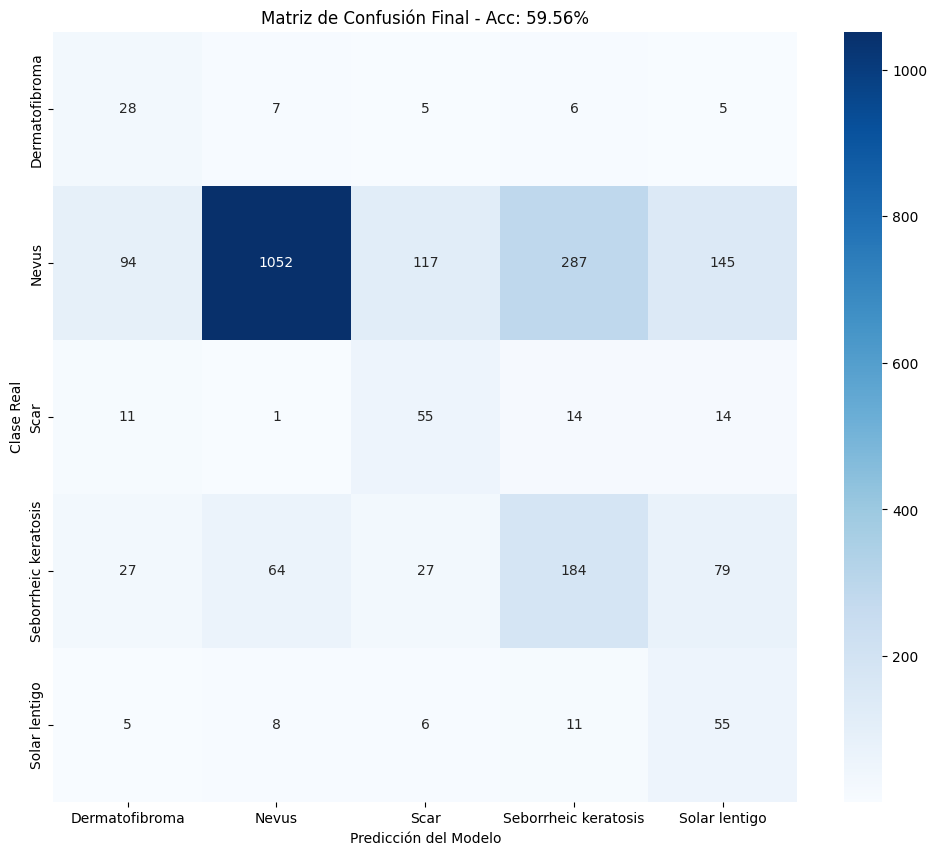

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

print("--- Iniciando Auditoría Final ---")
validation_generator.reset()
Y_pred = Modelo_Benigno.predict(validation_generator, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes

# Reporte Texto
class_names = list(validation_generator.class_indices.keys())
print("\nReporte de Clasificación Detallado:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Matriz de Confusión Gráfica
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción del Modelo')
plt.ylabel('Clase Real')
plt.title(f'Matriz de Confusión Final - Acc: {100*np.sum(y_pred==y_true)/len(y_true):.2f}%')
plt.show()

In [ ]:
import os

# Crear la carpeta para guardar los modelos si no existe
os.makedirs('/content/MisModelos', exist_ok=True)

# Guardar los modelos entrenados
print("Guardando modelo...")
Modelo_Benigno.save('/content/MisModelos/Modelo_2_Benigno.h5')

print("Modelos guardados exitosamente en /content/MisModelos/")

Guardando modelo...
Modelos guardados exitosamente en /content/MisModelos/


In [ ]:
from google.colab import files
import os

# Ruta del modelo específico que se guardó en la celda anterior
modelo_path = '/content/MisModelos/Modelo_2_Benigno.h5'

print(f"Intentando descargar el modelo: {os.path.basename(modelo_path)}")

# Verificar si el archivo del modelo existe antes de iniciar la descarga
if os.path.exists(modelo_path):
    files.download(modelo_path)
    print("\nDescarga completada exitosamente.")
else:
    print(f"\nError: No se encontró el archivo del modelo en la ruta especificada: {modelo_path}")
    print("Por favor, asegúrate de que la celda anterior para guardar el modelo se haya ejecutado sin errores.")

Intentando descargar el modelo: Modelo_2_Benigno.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Descarga completada exitosamente.


In [ ]:
import pandas as pd
import os

def convertir_csv_a_excel(ruta_csv, ruta_excel):
    """
    Lee un archivo CSV de métricas y lo convierte a un archivo XLSX.
    """
    if not os.path.exists(ruta_csv):
        print(f"Advertencia: El archivo CSV no fue encontrado en la ruta: {ruta_csv}")
        return False

    try:
        # Lee el archivo CSV con pandas
        df = pd.read_csv(ruta_csv)

        # Guardar el DataFrame como archivo Excel
        df.to_excel(ruta_excel, index=False)

        print(f"Métricas de '{ruta_csv}' guardadas exitosamente en: {ruta_excel}")
        return True

    except Exception as e:
        print(f"Error durante la conversión de '{ruta_csv}' a Excel: {e}")
        return False

In [ ]:
from google.colab import files

# Lista de los archivos CSV de registro que se generaron
archivos_csv_registros = [
    'registro_entrenamiento_modelo_Benigno.csv'
]

# Carpeta para guardar los archivos Excel
carpeta_excel = '/content/Metricas_Excel/'
os.makedirs(carpeta_excel, exist_ok=True)

print("--- Iniciando conversión y descarga de métricas ---")
for nombre_csv in archivos_csv_registros:
    nombre_excel = nombre_csv.replace('.csv', '.xlsx')
    ruta_excel_destino = os.path.join(carpeta_excel, nombre_excel)

    # Intentar convertir el archivo
    if convertir_csv_a_excel(nombre_csv, ruta_excel_destino):
        # Si la conversión fue exitosa, descargar el archivo
        print(f"Iniciando descarga de {ruta_excel_destino}...")
        files.download(ruta_excel_destino)

print("\n--- Proceso de conversión y descarga finalizado. ---")

--- Iniciando conversión y descarga de métricas ---
Métricas de 'registro_entrenamiento_modelo_Benigno.csv' guardadas exitosamente en: /content/Metricas_Excel/registro_entrenamiento_modelo_Benigno.xlsx
Iniciando descarga de /content/Metricas_Excel/registro_entrenamiento_modelo_Benigno.xlsx...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


--- Proceso de conversión y descarga finalizado. ---


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

from focal_loss import SparseCategoricalFocalLoss


ruta_dataset = '/content/dataset'

test_datagen = ImageDataGenerator(rescale=1./255)

print("Cargando imágenes de validación...")
validation_generator = test_datagen.flow_from_directory(
    os.path.join(ruta_dataset, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)


ruta_modelo = 'Modelo_2_Benigno.h5'

print(f"Cargando modelo desde: {ruta_modelo}...")
try:
    Modelo_Cargado = load_model(
        ruta_modelo,
        custom_objects={'SparseCategoricalFocalLoss': SparseCategoricalFocalLoss}
    )
    print("Modelo cargado exitosamente.")
except Exception as e:
    print(f"Error cargando el modelo: {e}")
    raise


Cargando imágenes de validación...
Found 2307 images belonging to 5 classes.
Cargando modelo desde: Modelo_2_Benigno.h5...


✅ Modelo cargado exitosamente.


--- Iniciando Auditoría Final ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


73/73 ━━━━━━━━━━━━━━━━━━━━ 21s 280ms/step

Reporte de Clasificación Detallado:
                      precision    recall  f1-score   support

      Dermatofibroma       0.19      0.55      0.28        51
               Nevus       0.92      0.69      0.79      1695
                Scar       0.30      0.63      0.41        95
Seborrheic keratosis       0.38      0.44      0.41       381
       Solar lentigo       0.22      0.62      0.32        85

            accuracy                           0.64      2307
           macro avg       0.40      0.59      0.44      2307
        weighted avg       0.76      0.64      0.68      2307



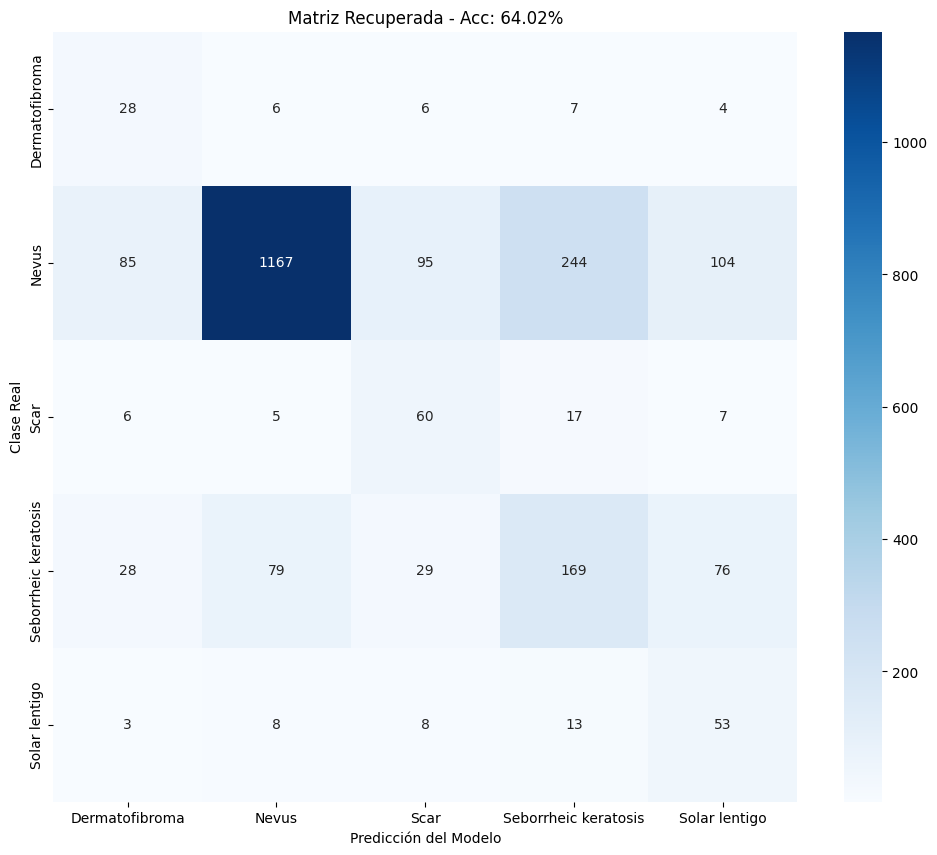

In [ ]:
print(" Iniciando Validación Final ")
# Reiniciar puntero por seguridad
validation_generator.reset()

# Predicción
Y_pred = Modelo_Cargado.predict(validation_generator, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes

# Reporte Texto
class_names = list(validation_generator.class_indices.keys())
print("\nReporte de Clasificación Detallado:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Matriz de Confusión Gráfica
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción del Modelo')
plt.ylabel('Clase Real')
plt.title(f'Matriz Recuperada - Acc: {100*np.sum(y_pred==y_true)/len(y_true):.2f}%')
plt.show()